# Chess Game Classification - EECS 731 Final Project
"The Outliers" - Patrick Canny & Mason Wilde

## Background
We set out to use our knowledge of Data Science to create a classification system for chess games. Chess is a fairly complicated game, with 10^120 games possible.

In [1]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data into inital dataframes
df = pd.read_csv("../data/csv/games.csv")

In [3]:
# Initial Look at our data
df.shape

(20058, 16)

In [4]:
pd.set_option('display.width', 10)
df.columns

Index(['id',
       'rated',
       'created_at',
       'last_move_at',
       'turns',
       'victory_status',
       'winner',
       'increment_code',
       'white_id',
       'white_rating',
       'black_id',
       'black_rating',
       'moves',
       'opening_eco',
       'opening_name',
       'opening_ply'],
      dtype='object')

A fairly small starter dataset to start with. Initially, some of the more interesting column names include: 
- **opening_name**: this feature could be used to determine what the most effective entry is for each color
- **winner**: this is what we will be predicting, but the column could also be used to get some general stats about how successful each color is given a variety of filters
- **moves**: this will give us an idea of how frequently given moves are made in the game, but we may have some issues interpereting them
- **rated**: interestingly, we could see if rated games are more contested than non-rated games.
- **created_at/last_move_at**: this can give us the total time of a given game

In [5]:
df['created_at'] = df['created_at'].astype('int64')
df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1504210000000,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1504130000000,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1504130000000,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1504110000000,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1504030000000,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [6]:
# Create Game Length feature
df["game_length"] = df["created_at"] - df["last_move_at"]

In [7]:
len(df['game_length'].nonzero()[0])

11510

It appears that about half of the games in this dataset have a non-zero game length, which is not exactly what we want to see.

The next thing I did was install the python-chess package. It has a pretty nice API for interacting with PGN files, which we will need to use in this project

In [8]:
import chess

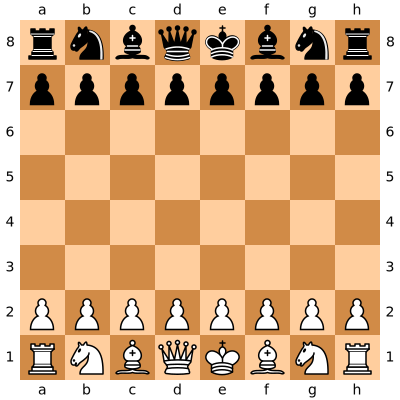

In [9]:
board = chess.Board()
board